### This in-depth tutorial will teach you how to easily create your first deep learning model from scratch, using Pytorch and then FastAI!

# Sources

* https://github.com/fastai/fastbook/blob/master/04_mnist_basics.ipynb
* https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
* https://www.kaggle.com/thinhntr/digit-recognizer-using-fastai-v2-mar-2021

# Imports

In [ ]:
import numpy as np
import pandas as pd

from fastai.vision.all import *
from tqdm import tqdm
import pickle, gzip, math, torch, matplotlib as mpl
import torch.nn.functional as F
import pathlib
from pathlib import Path

#Mixed-precision training
from fastai.callback.fp16 import *

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Gather Data

The first thing to do is to gather and prepare our dataset. Here, we have 28x28 grayscale images. Each line of the dataframe represents a 784 pixels image, as well as the label associated to the image (a number between 0 and 9).
If we want to visualize the images, we can transform this dataset into a tensor (which allows to make calculations on the GPU) of size 42000x28x28 because : 
* We have 42000 images,
* Each image is of size 28x28.

In [ ]:
training_df_all = pd.read_csv("../input/digit-recognizer/train.csv")
testing_df_all = pd.read_csv("../input/digit-recognizer/test.csv")
sample_submission = pd.read_csv("../input/digit-recognizer/sample_submission.csv")

In [ ]:
valid_df = training_df_all[35000:42000]
training_df = training_df_all[0:34999]

In [ ]:
training_df.tail()

We will also divide each number in our tensor by 255 here, in order to normalize it. The unsqueeze() method is here to add a dimension to the label tensor. 

In [ ]:
x_train = torch.tensor(training_df.drop(['label'], axis = 1).values).float() / 255.0
y_train = torch.tensor(training_df.label.values).float().unsqueeze(1)
x_valid = torch.tensor(valid_df.drop(['label'], axis = 1).values).float() / 255.0
y_valid = torch.tensor(valid_df.label.values).float().unsqueeze(1)

print(x_train.shape, y_train.shape)

In [ ]:
# Reshape image in 3 dimensions (height = 28px, width = 28px) for visualization purposes
x_train_image = torch.reshape(x_train, (-1,28,28))
print(x_train_image.shape)

2 ways to plot an image:

In [ ]:
show_image(x_train_image[0])

In [ ]:
plt.imshow(x_train_image[0])

# Describe the deep learning approach

we could look at each individual pixel and come up with a set of weights for each one, such that the highest weights are associated with those pixels most likely to be black for a particular category. For instance, pixels toward the bottom right are not very likely to be activated for a 7, so they should have a low weight for a 7, but they are likely to be activated for an 8, so they should have a high weight for an 8. This can be represented as a function and set of weight values for each possible category—for instance the probability of being the number 8:

def pr_eight(x,w): return (x*w).sum()

Here we are assuming that x is the image, represented as a vector—in other words, with all of the rows stacked up end to end into a single long line. And we are assuming that the weights are a vector w. If we have this function, then we just need some way to update the weights to make them a little bit better. With such an approach, we can repeat that step a number of times, making the weights better and better, until they are as good as we can make them.

We want to find the specific values for the vector w that causes the result of our function to be high for those images that are actually 8s, and low for those images that are not. Searching for the best vector w is a way to search for the best function for recognising 8s. (Because we are not yet using a deep neural network, we are limited by what our function can actually do).

To be more specific, here are the steps that we are going to require, to turn this function into a machine learning classifier:

1. **Initialization:** Initialize the weights.
1. **Prediction:** For each image, use these weights to predict which number it appears to be.
1. **Compute loss:** Based on these predictions, calculate how good the model is (its loss).
1. **Compute gradient:** Calculate the gradient, which measures for each weight, how changing that weight would change the loss
1. **Modify weights:** Step (that is, change) all the weights based on that calculation.
1. **Repeat step 2 to 5 n times:** Go back to the step 2, and repeat the process.
1. **Stop:** Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).

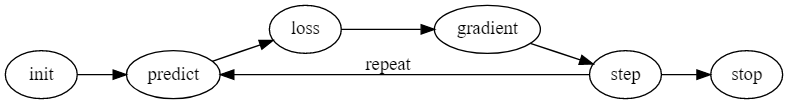

There are many different ways to do each of these seven steps. These are the details that make a big difference for deep learning practitioners, but it turns out that the general approach to each one generally follows some basic principles. Here are a few guidelines:

* **Initialize**: We initialize the parameters to random values. This may sound surprising. There are certainly other choices we could make, such as initializing them to the percentage of times that pixel is activated for that category—but since we already know that we have a routine to improve these weights, it turns out that just starting with random weights works perfectly well.
* **Loss**: We need some function that will return a number that is small if the performance of the model is good (the standard approach is to treat a small loss as good, and a large loss as bad, although this is just a convention).
* **Step**: A simple way to figure out whether a weight should be increased a bit, or decreased a bit, would be just to try it: increase the weight by a small amount, and see if the loss goes up or down. Once you find the correct direction, you could then change that amount by a bit more, and a bit less, until you find an amount that works well. However, this is slow! As we will see, the magic of calculus allows us to directly figure out in which direction, and by roughly how much, to change each weight, without having to try all these small changes. The way to do this is by calculating gradients. This is just a performance optimization, we would get exactly the same results by using the slower manual process as well.
* **Stop**: Once we've decided how many epochs to train the model for (a few suggestions for this were given in the earlier list), we apply that decision. This is where that decision is applied. For our digit classifier, we would keep training until the accuracy of the model started getting worse, or we ran out of time.

# Illustrate the seven steps with a simple example

The following example illustrates what happens in 2 dimensions, assuming that we want to find the minimum of the function f: x -> x^2.
In reality, it is exactly the same thing that happens: for each parameter, we want to modify its associated weight in order to minimize the loss.

**Initialization**: We first take a random x value.

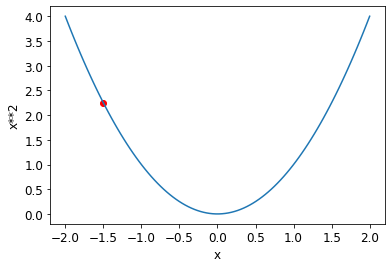

**Prediction**: Here, the prediction simply corresponds to our x value.

**Compute Loss**: Here, we can just make the difference between our x value and the xmin value in order to compute the loss (loss = 1,5) 

**Compute Gradient:** We compute the derivative of our function f, and we look at the value of our slope to get our gradient. The sign of the slope allows us to know if we should increase or decrease our weight. The value of the slope allows us to determine the intensity of our modification. 

One important thing to be aware of is that our function has lots of weights that we need to adjust, so when we calculate the derivative we won't get back one number, but lots of them—a gradient for every weight. But there is nothing mathematically tricky here; you can calculate the derivative with respect to one weight, and treat all the other ones as constant, then repeat that for each other weight. This is how all of the gradients are calculated, for every weight.

We mentioned just now that you won't have to calculate any gradients yourself. How can that be? Amazingly enough, PyTorch is able to automatically compute the derivative of nearly any function! What's more, it does it very fast. Most of the time, it will be at least as fast as any derivative function that you can create by hand.

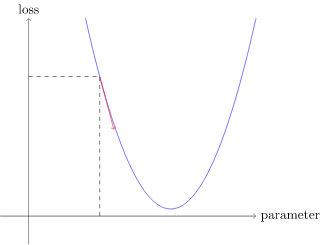

**Modify weights:** Deciding how to change our parameters based on the values of the gradients is an important part of the deep learning process. Nearly all approaches start with the basic idea of multiplying the gradient by some small number, called the learning rate (LR). The learning rate is often a number between 0.001 and 0.1, although it could be anything. Often, people select a learning rate just by trying a few, and finding which results in the best model after training. Once you've picked a learning rate, you can adjust your parameters using this simple function:

w -= gradient(w) * lr

This is known as stepping your parameters, using an optimizer step.

Choosing the adequate learning rate is very important:
* If you pick a learning rate that's too low, it can mean having to do a lot of steps,
* But picking a learning rate that's too high is even worse—it can actually result in the loss getting worse,
* If the learning rate is too high, it may also "bounce" around, rather than actually diverging.

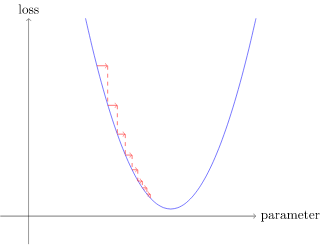
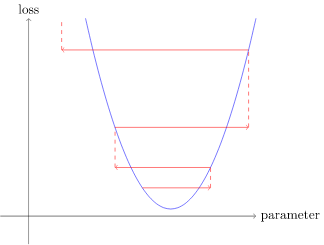
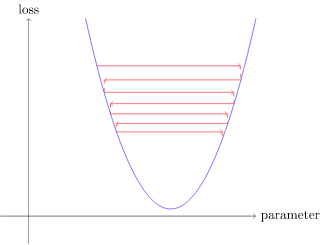

# Summarize the method

To summarize, at the beginning, the weights of our model can be random (training from scratch) or come from a pretrained model (transfer learning). In the first case, the output we will get from our inputs won't have anything to do with what we want, and even in the second case, it's very likely the pretrained model won't be very good at the specific task we are targeting. So the model will need to learn better weights.

We begin by comparing the outputs the model gives us with our targets (we have labeled data, so we know what result the model should give) using a loss function, which returns a number that we want to make as low as possible by improving our weights. To do this, we take a few data items (such as images) from the training set and feed them to our model. We compare the corresponding targets using our loss function, and the score we get tells us how wrong our predictions were. We then change the weights a little bit to make it slightly better.

To find how to change the weights to make the loss a bit better, we use calculus to calculate the gradients. (Actually, we let PyTorch do it for us!) Let's consider an analogy. Imagine you are lost in the mountains with your car parked at the lowest point. To find your way back to it, you might wander in a random direction, but that probably wouldn't help much. Since you know your vehicle is at the lowest point, you would be better off going downhill. By always taking a step in the direction of the steepest downward slope, you should eventually arrive at your destination. We use the magnitude of the gradient (i.e., the steepness of the slope) to tell us how big a step to take; specifically, we multiply the gradient by a number we choose called the learning rate to decide on the step size. We then iterate until we have reached the lowest point, which will be our parking lot, then we can stop.

All of that we just saw can be transposed directly to the MNIST dataset, except for the loss function. Let's now see how we can define a good training objective.

# First model with Pytorch

## Step 0: Preparation

First of all, we need to create what we call a **Dataset**. The dataset links each input data (here, each image) to its label.

A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

In [ ]:
dset = list(zip(x_train,y_train.squeeze(1).long()))
valid_dset = list(zip(x_valid,y_valid.squeeze(1).long()))
x,y = dset[0]
x.shape,y

In order to take an optimization step we need to calculate the loss over one or more data items. How many should we use? We could calculate it for the whole dataset, and take the average, or we could calculate it for a single data item. But neither of these is ideal. Calculating it for the whole dataset would take a very long time. Calculating it for a single item would not use much information, so it would result in a very imprecise and unstable gradient. That is, you'd be going to the trouble of updating the weights, but taking into account only how that would improve the model's performance on that single item.

So instead we take a compromise between the two: we calculate the average loss for a few data items at a time. This is called a **mini-batch**. The number of data items in the mini-batch is called the **batch size**. A larger batch size means that you will get a more accurate and stable estimate of your dataset's gradients from the loss function, but it will take longer, and you will process fewer mini-batches per epoch. **Choosing a good batch size is one of the decisions you need to make as a deep learning practitioner to train your model quickly and accurately**.

That is why we also need a **Dataloader**. A DataLoader can take any Python collection and turn it into an iterator over many batches.

When we pass a Dataset to a DataLoader we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables

In [ ]:
dl = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

## Step 1: Initialization

We need an (initially random) weight for every pixel (this is the initialize step in our seven-step process).

The function weights times pixels won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). Thus, we need a bias b. In neural networks, the w in the equation y=w*x+b is called the weights, and the b is called the bias. Together, the weights and bias make up the parameters.

In [ ]:
def init_params(size, std=1.0): 
    return (torch.randn(size)*std).requires_grad_()

The shape of our weights should be 784x10, because at the end of our model, we want to get 10 predictions, one for each number between 0 and 9. We can then take the argmax of each value. The largest value obtained will be our prediction.

In [ ]:
weights = init_params((28*28,10))
bias = init_params(10)
weights[0], bias[0]

## Step 2: Prediction

In [ ]:
# def linear1(xb): 
#     return xb@weights + bias

# preds = linear1(x_train)
# preds[0]

### <span style="color:blue">Bonus ! Adding a Nonlinearity</span>

<span style="color:blue">So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.</span>

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

w1 = init_params((28*28,50))
b1 = init_params(50)
w2 = init_params((50,10))
b2 = init_params(10)

preds = simple_net(x_train)
preds[0], preds.shape

<span style="color:blue">That little function res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU. We think we can all agree that rectified linear unit sounds pretty fancy and complicated... But actually, there's nothing more to it than res.max(tensor(0.0))—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as F.relu:</span>

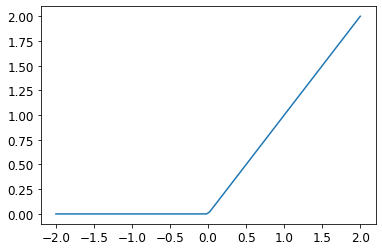

## Step 3: Compute Loss - Cross Entropy

A lot of loss functions exists, each of them is helpful in some specific situations. Four our problem, a good loss function is cross-entropy.

* For more info about cross entropy, check https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e
* For even more info about the maths behind cross-entropy, check III.7) of https://www.kaggle.com/toldo171/digit-recognition-from-scratch

In a word, cross-entropy is defined as:

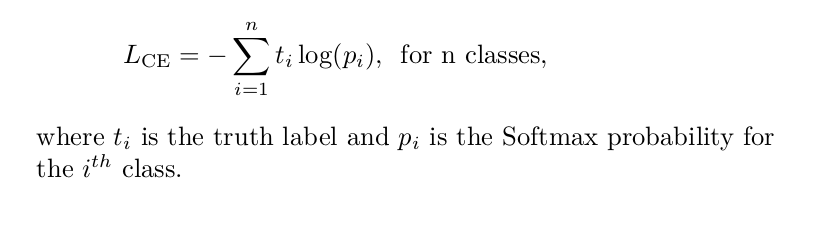

First, we will need to compute the softmax of our activations. This is defined by:
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:
$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum_{0 \leq j \leq n-1} e^{x_{j}}}$$


Then, if we consider a classification problem where the model has to determine if an image is a 1, 2, 3 or 4, and the softmax probabilities (S) and labels (T) of the model are:

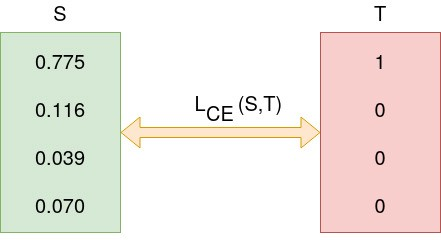

then the categorical cross-entropy is computed as follows:

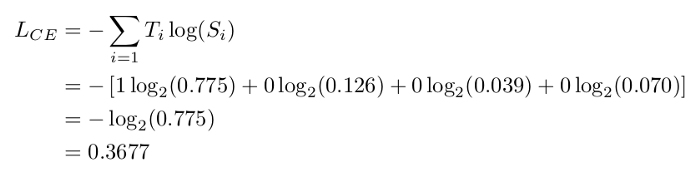

Softmax is continuously differentiable function. This makes it possible to calculate the derivative of the loss function with respect to every weight in the neural network. This property allows the model to adjust the weights accordingly to minimize the loss function (model output close to the true values).

In PyTorch, F.log_softmax and F.nll_loss are combined in one optimized function, F.cross_entropy.

In [ ]:
loss_func = F.cross_entropy

## Step 4: Compute Gradient

This step is pretty straightforward: we compute our predictions and then the loss between our predictions and the real values, using softmax activations and cross entropy loss (regrouped in *F.cross_entropy*).

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = loss_func(preds, yb)
    loss.backward()

## Step 5: Update weights

Our only remaining step is to update the weights and biases based on the gradient and learning rate (**i.e. param = param - param_grad * lr**). When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

## Step 6, 7: Combining everything

We also want to check how we're doing, by looking at the accuracy of the validation set, so let's define an accuracy metric. We take the argmax of our output, to find out which of the numbers of the softmax is the highest. The index of that is our prediction. Then we check if it's equal with the real value, and we take the mean of it.

In [ ]:
def accuracy(out, yb): 
    return (torch.argmax(out, dim=1)==yb).float().mean()

def validate_epoch(model):
    accs = [accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

Let's try to run this for one batch (256 images) to see if everything works:

In [ ]:
preds = simple_net(xb)
print(preds[0], preds.shape)
print(loss_func(preds, yb))
print(accuracy(preds, yb))

That's our starting point. We have around 10% accuracy, which is totally normal since our initialisation step was done randomly. Let's train for one epoch, and see if the accuracy improves:

In [ ]:
lr = 1
params = w1, b1, w2, b2
train_epoch(simple_net, lr, params)
validate_epoch(simple_net)

It works! Let's try for a few more epochs:

In [ ]:
for i in range(20):
    train_epoch(simple_net, lr, params)
    print(validate_epoch(simple_net), end=' ')

And this is it! The rest is only "tricks" to improve the results, but here **we just finished our first deep learning model from scratch!**

# Condense code using Pytorch

We can factorize the above elements as follows:

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,50),
    nn.ReLU(),
    nn.Linear(50,10)
)

w1, b1, w2, b2 = simple_net.parameters()
print(w1.shape,b1.shape,w2.shape,b2.shape)

opt = SGD(simple_net.parameters(), lr)

def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()
        
validate_epoch(simple_net)

def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

train_model(simple_net, 20)

# Condense code using FastAI

We can now use FastAI to do the same thing. As you can see, we now know how to do from scratch everything that is written in the function:
* The learner is given a dataloader,
* The optimization method is SGD (what we did above)
* The loss function used to optimize the model is the cross-entropy loss,
* The metric used to define the efficiency of our model is the accuracy

In [ ]:
dls = DataLoaders(dl, valid_dl)
learn = Learner(dls, simple_net, opt_func=SGD, loss_func=F.cross_entropy, metrics=accuracy)

In [ ]:
learn.fit(10, lr=0.01)

At this point we have something that is rather magical:

1. A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
1. A way to find the best set of parameters for any function (stochastic gradient descent)

This is why deep learning can do things which seem rather magical, such fantastic things. Believing that this combination of simple techniques can really solve any problem is one of the biggest steps that we find many students have to take. It seems too good to be true—surely things should be more difficult and complicated than this? Our recommendation: try it out! We just tried it on the MNIST dataset and you have seen the results. And since we are doing everything from scratch ourselves (except for calculating the gradients) you know that there is no special magic hiding behind the scenes.

# Going further with FastAI

## Prepare the data

We now want to use an advanced image classification architecture, so we need to convert our data so that FastAI understands that they are images.

In [ ]:
path = Path('/kaggle/working')
train_path = path/'train'
test_path = path/'test'
train_path.mkdir()
test_path.mkdir()

for i, row in tqdm(enumerate(training_df_all.values)):
    dir = train_path/str(row[0])
    dir.mkdir(exist_ok=True)
    img_arr = row[1:].reshape(28, 28).astype(np.uint8)
    Image.fromarray(img_arr, "L").save(dir/f"{i}.png")
    
for i, row in tqdm(enumerate(testing_df_all.values)):
    img_arr = row.reshape(28, 28).astype(np.uint8)
    Image.fromarray(img_arr, "L").save(test_path/f"{i}.png")
    
mnist = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    batch_tfms=Normalize(imagenet_stats)
)

## Reminder: Datasets and Dataloaders

* **Dataset**: A collection that returns a tuple of your independent and dependent variable for a single item
* **DataLoader**: An iterator that provides a stream of mini-batches, where each mini-batch is a tuple of a batch of independent variables and a batch of dependent variables

On top of these, fastai provides two classes for bringing your training and validation sets together:

* **Datasets**::An object that contains a training Dataset and a validation Dataset
* **DataLoaders**: An object that contains a training DataLoader and a validation DataLoader

## Find a good learning rate

One of the most important things we can do when training a model is to make sure that we have the right learning rate. If our learning rate is too low, it can take many, many epochs to train our model. Not only does this waste time, but it also means that we may have problems with overfitting, because every time we do a complete pass through the data, we give our model a chance to memorize it.

What do we do to find the perfect learning rate—not too high, and not too low? In 2015 the researcher Leslie Smith came up with a brilliant idea, called the learning rate finder. His idea was to start with a very, very small learning rate, something so small that we would never expect it to be too big to handle. We use that for one mini-batch, find what the losses are afterwards, and then increase the learning rate by some percentage (e.g., doubling it each time). Then we do another mini-batch, track the loss, and double the learning rate again. We keep doing this until the loss gets worse, instead of better. This is the point where we know we have gone too far. We then select a learning rate a bit lower than this point. Our advice is to pick either:

* One order of magnitude less than where the minimum loss was achieved (i.e., the minimum divided by 10)
* The last point where the loss was clearly decreasing

The learning rate finder computes those points on the curve to help you. Both these rules usually give around the same value.

## Add mixed-precision training

One of the downside of deeper architectures is that they take quite a bit longer to train. One technique that can speed things up a lot is **mixed-precision training**. This refers to using less-precise numbers (half-precision floating point, also called fp16) where possible during training. As we are writing these words in early 2020, nearly all current NVIDIA GPUs support a special feature called tensor cores that can dramatically speed up neural network training, by 2-3x. They also require a lot less GPU memory. To enable this feature in fastai, just add **to_fp16()** after your Learner creation (you also need to import the module). **It often even improve the accuracy of the model**, because it adds a tiny bit of randomness to it! (not always though)

## Add weight decay

Weight decay, or L2 regularization, consists in adding to your loss function the sum of all the weights squared. Why do that? Because when we compute the gradients, it will add a contribution to them that will encourage the weights to be as small as possible.

Why would it prevent overfitting? The idea is that the larger the coefficients are, the sharper canyons we will have in the loss function. If we take the basic example of a parabola, y = a * (x**2), the larger a is, the more narrow the parabola is

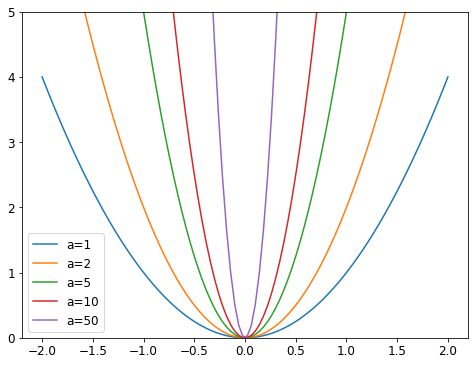

So, letting our model learn high parameters might cause it to fit all the data points in the training set with an overcomplex function that has very sharp changes, which will lead to overfitting.

Limiting our weights from growing too much is going to hinder the training of the model, but it will yield a state where it generalizes better. Going back to the theory briefly, weight decay (or just wd) is a parameter that controls that sum of squares we add to our loss (assuming parameters is a tensor of all parameters):

loss_with_wd = loss + wd * (parameters^2).sum()
In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, you might recall that the derivative of p^2 with respect to p is 2*p, so adding that big sum to our loss is exactly the same as doing:

parameters.grad += wd * 2 * parameters
In practice, since wd is a parameter that we choose, we can just make it twice as big, so we don't even need the *2 in this equation. To use weight decay in fastai, just pass wd in your call to fit or fit_one_cycle:

In [ ]:
dls = mnist.dataloaders(train_path, batch_size=64)
arch = models.resnet18

learn = cnn_learner(dls, arch, pretrained=True, loss_func=F.cross_entropy, metrics=accuracy).to_fp16()

lr_min, lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

We want to train a model in such a way that we allow it to remember all of these generally useful ideas from the pretrained model, use them to solve our particular task (classify pet breeds), and only adjust them as required for the specifics of our particular task.

Our challenge when fine-tuning is to replace the random weights in our added linear layers with weights that correctly achieve our desired task (classifying pet breeds) without breaking the carefully pretrained weights and the other layers. There is actually a very simple trick to allow this to happen: tell the optimizer to only update the weights in those randomly added final layers. Don't change the weights in the rest of the neural network at all. This is called freezing those pretrained layers.

When we create a model from a pretrained network fastai automatically freezes all of the pretrained layers for us. When we call the **fine_tune** method (i.e. **learn.fine_tune(2, base_lr=3e-3)** fastai does two things:

* Trains the randomly added layers for one epoch, with all other layers frozen,
* Unfreezes all of the layers, and trains them all for the number of epochs requested (here, 2).

Although this is a reasonable default approach, it is likely that for your particular dataset you may get better results by doing things slightly differently. The fine_tune method has a number of parameters you can use to change its behavior, but it might be easiest for you to just call the underlying methods directly if you want to get some custom behavior.

## My personal method

I personaly prefer to do it manually. Basically here is what I do:

* I call **learn.fit_one_cycle(5, lr_min)**, which will train the model only on the last layers for a few epochs, at the learning rate defined by the learning rate finder.
* I unfreeze the other layers,
* I run the learning rate finder again, to adjust it,
* I re-train for a few epochs, using the "**discriminative learning rate**" method.

In [ ]:
learn.fit_one_cycle(5, lr_min, wd=0.1)

In [ ]:
learn.unfreeze()

In [ ]:
lr_min, lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

## Discriminative learning rates

Even after we unfreeze, we still care a lot about the quality of those pretrained weights. We would not expect that the best learning rate for those pretrained parameters would be as high as for the randomly added parameters, even after we have tuned those randomly added parameters for a few epochs. Remember, the pretrained weights have been trained for hundreds of epochs, on millions of images.

Therefore, fastai's default approach is to use discriminative learning rates.

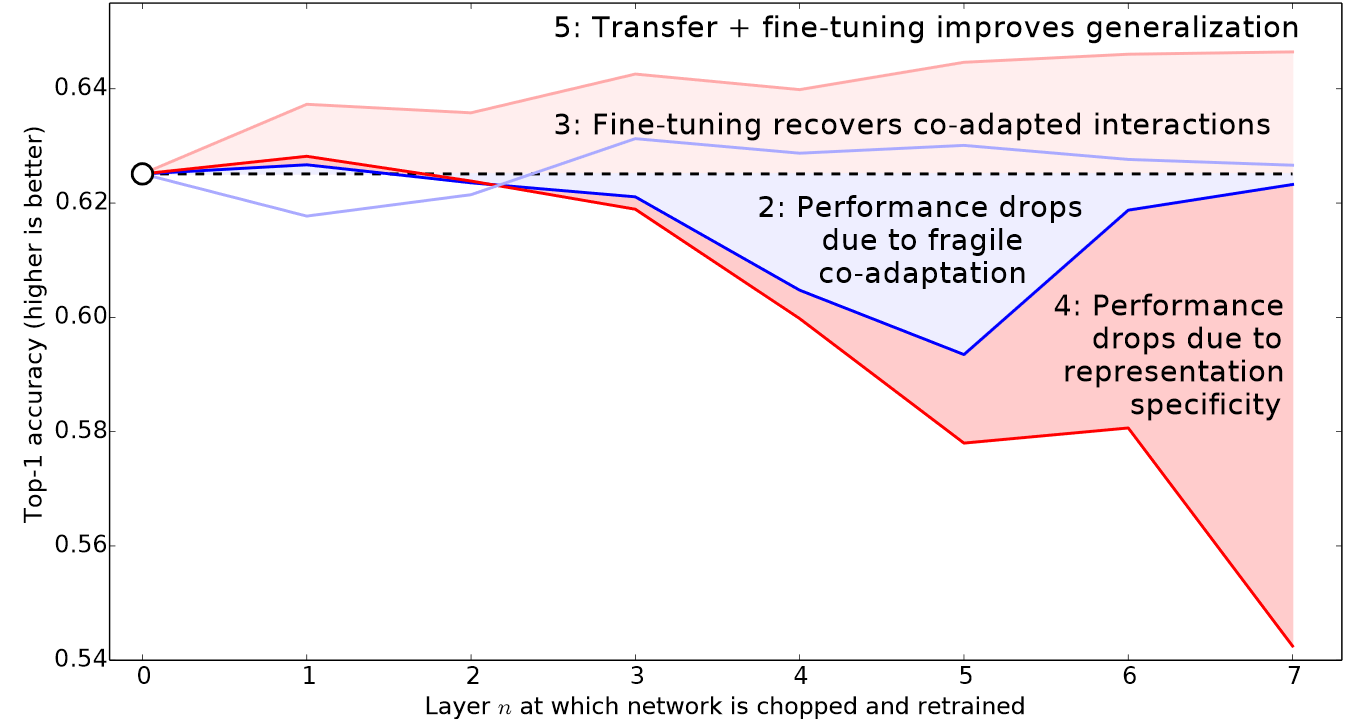

Fastai lets you pass a Python slice object anywhere that a learning rate is expected. The first value passed will be the learning rate in the earliest layer of the neural network, and the second value will be the learning rate in the final layer. The layers in between will have learning rates that are multiplicatively equidistant throughout that range.

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(lr_min/10,lr_min*10), wd=0.1)

Here, we are having a hard time improving the accuracy after unfreezing the model.

## Visualize the results

Fastai can show us a graph of the training and validation loss.

**Remember: when the validation loss starts to rise and the training loss continues to fall, you are starting to overfit!**

In [ ]:
learn.recorder.plot_loss()

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

## <span style="color:red">Summary of all technics and tricks to use/test</span>

### <span style="color:red">First model</span>

* <span style="color:red">Choose a good archiecture (**resnet 18, 34, 50**, or anything else)</span>
* <span style="color:red">Use **pretrained weights** (or not)</span>
* <span style="color:red">Choose the good loss function (here, **cross-entropy**)</span>
* <span style="color:red">Choose a good **accuracy metric**</span>
* <span style="color:red">Find a good learning rate with lr_finder (**learn.lr_find()**)</span>

### <span style="color:red">Going further:</span>

* <span style="color:red">Add mixed-precision training (**.to_fp16()**)</span>
* <span style="color:red">Add weight decay (**wd=0.1** or any other value that fits better)</span>
* <span style="color:red">Use discriminative learning rates (**learn.unfreeze()** and **learn.fit_one_cycle(5, lr_max=slice(lr_min/10,lr_min*10), wd=0.1)**)</span>
* <span style="color:red">More to come: Mix-up, TTA, Dropout...</span>

# For the fame: Predict and export submission

In [ ]:
test_len = len(test_path.ls())
test_fns = L()
# sort test file names (0.png, 1.png, 2.png, ...)
for i in tqdm(range(test_len)):
    fn = test_path/f"{i}.png"
    test_fns.append(fn)

test_dl = dls.test_dl(test_fns)

In [ ]:
preds = learn.get_preds(dl=test_dl)[0].argmax(dim=1)
preds

In [ ]:
df_result = pd.DataFrame(
    {
        "Label": preds.tolist()
    }
)
df_result.index += 1
df_result.head()

In [ ]:
df_result.to_csv("submission.csv", index_label="ImageId")